In [13]:
# Library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.auto import tqdm
import statsmodels
import statsmodels.api as sm

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_pinball_loss
from lightgbm import LGBMRegressor

import warnings
warnings.simplefilter('ignore')

In [14]:
seed = 1

In [15]:
train_df = pd.read_csv('../data/train_data.csv')
test_df = pd.read_csv('../data/test_data.csv')
submission_df = pd.read_csv('../data/submission.csv')

In [16]:
def preprocessing(df, mode='train'):
    df_tmp = df.copy()
    input_year = 2021

    df_tmp['time'] = pd.to_datetime(df_tmp.date, format='%m/%d')
    df_tmp['year'] = df_tmp['time'].dt.year
    df_tmp['month'] = df_tmp['time'].dt.month
    df_tmp['day'] = df_tmp['time'].dt.day
    if mode=='train':
        df_tmp.loc[df_tmp['month']>3, 'year'] = input_year
        df_tmp.loc[df_tmp['month']<=3, 'year'] = input_year + 1
    else:
        df_tmp['year'] = input_year + 1
    df_tmp['time'] = pd.to_datetime({'year':df_tmp.year, 'month':df_tmp.month, 'day':df_tmp.day})
    df_tmp['weekday'] = df_tmp['time'].dt.weekday
    return df_tmp

train_df = preprocessing(train_df, mode='train')
test_df = preprocessing(test_df, mode='test')

In [17]:
train_df.columns

Index(['id', 'date', 'highest', 'lowest', 'rain', 'ice1', 'ice2', 'ice3',
       'oden1', 'oden2', 'oden3', 'oden4', 'hot1', 'hot2', 'hot3', 'dessert1',
       'dessert2', 'dessert3', 'dessert4', 'dessert5', 'drink1', 'drink2',
       'drink3', 'drink4', 'drink5', 'drink6', 'alcol1', 'alcol2', 'alcol3',
       'snack1', 'snack2', 'snack3', 'bento1', 'bento2', 'bento3', 'bento4',
       'tild1', 'tild2', 'men1', 'men2', 'men3', 'men4', 'men5', 'men6',
       'time', 'year', 'month', 'day', 'weekday'],
      dtype='object')

In [18]:
target_columns = ['ice1', 'ice2', 'ice3',
    'oden1', 'oden2', 'oden3', 'oden4', 'hot1', 'hot2', 'hot3', 'dessert1',
    'dessert2', 'dessert3', 'dessert4', 'dessert5', 'drink1', 'drink2',
    'drink3', 'drink4', 'drink5', 'drink6', 'alcol1', 'alcol2', 'alcol3',
    'snack1', 'snack2', 'snack3', 'bento1', 'bento2', 'bento3', 'bento4',
    'tild1', 'tild2', 'men1', 'men2', 'men3', 'men4', 'men5', 'men6']

In [25]:
# 検証データのindexを指定(訓練データの最後2ヶ月を使用)
# valid_index = range(297,351) # month:2,3
valid_index = range(325,351) # month:3

# 予測結果を保存する辞書型データ
results = dict({})
all_lgb_score = []

# 商品ごとの予測を作成
for c in tqdm(target_columns):
    train_tmp = train_df.copy()
    test_tmp = test_df.copy()
    
    #ice
    if c in ['ice1', 'ice2', 'ice3']:
        # 予測期間はアイスが人気な7, 8 ,9月ではないので除外
        train_tmp = train_tmp[~train_tmp['month'].isin([7, 8, 9])]
        # アイスは金曜に人気
        train_tmp['is_wday4'] = train_df['weekday'].isin([4]).astype(int)
        test_tmp['is_wday4'] = test_df['weekday'].isin([4]).astype(int)
    # oden
    elif c in ['oden1', 'oden2', 'oden3', 'oden4']:
        # おでんやって無い夏は考えない
        train_tmp = train_tmp[train_tmp['month'].isin([10, 11, 12, 1, 2, 3])]
        # おでんは水木で人気
        train_tmp['is_wday23'] = train_df['weekday'].isin([2, 3]).astype(int)
        test_tmp['is_wday23'] = test_df['weekday'].isin([2, 3]).astype(int)
    # hot
    elif c in ['hot1', 'hot2', 'hot3']:
        # ホットスナックは月、火、金で不人気
        train_tmp['is_wday014'] = train_df['weekday'].isin([0,1,4]).astype(int)
        test_tmp['is_wday014'] = test_df['weekday'].isin([0,1,4]).astype(int)
    # dessert
    elif c in ['dessert1', 'dessert2', 'dessert3', 'dessert4', 'dessert5']:
        # デザートは水曜と日曜で人気
        train_tmp['is_wday36'] = train_df['weekday'].isin([3,6]).astype(int)
        test_tmp['is_wday36'] = test_df['weekday'].isin([3,6]).astype(int)
    # drink1456
    elif c in ['drink1', 'drink4', 'drink5', 'drink6']:
        # 夏に人気なドリンクは夏のデータは使わない
        train_tmp = train_tmp[~train_tmp['month'].isin([7, 8, 9])]
        # 金曜に人気
        train_tmp['is_wday4'] = train_df['weekday'].isin([4]).astype(int)
        test_tmp['is_wday4'] = test_df['weekday'].isin([4]).astype(int)
    # drink23
    elif c in ['drink2', 'drink3']:
        # 常に人気が変わらないドリンクは全期間つかう。火曜に人気
        train_tmp['is_wday1'] = train_df['weekday'].isin([1]).astype(int)
        test_tmp['is_wday1'] = test_df['weekday'].isin([1]).astype(int)
    # alcohol
    elif c in ['alcol1', 'alcol2', 'alcol3']:
        # 酒は水木で人気
        train_tmp['is_wday23'] = train_df['weekday'].isin([2, 3]).astype(int)
        test_tmp['is_wday23'] = test_df['weekday'].isin([2, 3]).astype(int)
    # snack
    elif c in ['snack1', 'snack2', 'snack3']:
        train_tmp['is_wday0'] = train_df['weekday'].isin([0]).astype(int)
        train_tmp['is_wday14'] = train_df['weekday'].isin([1,4]).astype(int)
        test_tmp['is_wday0'] = test_df['weekday'].isin([0]).astype(int)
        test_tmp['is_wday14'] = test_df['weekday'].isin([1,4]).astype(int)
    # bento
    elif c in ['bento1', 'bento2', 'bento3', 'bento4']:
        # 弁当は月、火、金で不人気
        train_tmp['is_wday014'] = train_df['weekday'].isin([0,1,4]).astype(int)
        test_tmp['is_wday014'] = test_df['weekday'].isin([0,1,4]).astype(int)
    # tild
    elif c in ['tild1', 'tild2']:
        # 日曜に人気
        train_tmp['is_wday6'] = train_df['weekday'].isin([6]).astype(int)
        test_tmp['is_wday6'] = test_df['weekday'].isin([6]).astype(int)
    # men
    elif c in ['men1', 'men2', 'men3', 'men4', 'men5', 'men6']:
        train_tmp['is_wday014'] = train_df['weekday'].isin([0,1,4]).astype(int)
        test_tmp['is_wday014'] = test_df['weekday'].isin([0,1,4]).astype(int)
    
    # id, rain, highest, lowest, year, month, day, weekday, 自分で付け加えた特徴量
    train_columns = [c for c in train_tmp.columns if c not in target_columns if c not in ['date', 'time']]
    
    X_train = train_tmp[~train_tmp['id'].isin(valid_index)][train_columns]
    y_train = train_tmp[~train_tmp['id'].isin(valid_index)][c]
    X_valid = train_tmp[train_tmp['id'].isin(valid_index)][train_columns]
    y_valid = train_tmp[train_tmp['id'].isin(valid_index)][c]
    X_test = test_tmp[train_columns]
    
    # 分位点
    qs = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
    
    # 分位点ごとのベストスコア
    lgb_scores = []
    
    # 分位点ごとにモデルを作成
    for q in qs:
        lgb = LGBMRegressor(
            objective='quantile',
            alpha = q,
            n_estimators=10000,
            max_depth=5,
            colsample_bytree=0.9,
            random_state=seed
        )
        
        # 学習
        lgb.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=100, verbose=False)
        lgb_scores.append(lgb.best_score_['valid_0']['quantile'])
        
        # 予測
        y_pred = lgb.predict(X_test)
        results[(c, q)] = y_pred
    
    all_lgb_score.append(lgb_scores)

score_df = pd.DataFrame(np.array(all_lgb_score), columns=qs, index=target_columns)
display(score_df)

print(f'ave score: {np.array(all_lgb_score).mean()}')

  0%|          | 0/39 [00:00<?, ?it/s]

,0.01,0.10,0.50,0.90,0.99
ice1,0.037035,0.277754,0.808488,0.613401,0.080427
ice2,0.087115,0.414187,0.524709,0.435196,0.327723
ice3,0.054648,0.448462,1.370255,0.438075,0.059550
oden1,0.438458,2.707773,2.933577,1.646637,0.332239
oden2,0.379042,2.215908,3.114634,3.262724,1.147685
oden3,0.811430,6.704831,5.816060,4.014711,0.655564
oden4,0.425201,4.025403,4.758763,3.726690,0.978794
hot1,0.242126,1.200107,3.344874,1.836105,0.634443
hot2,0.258330,2.347196,6.436012,2.668861,0.452483
hot3,0.276897,2.054874,5.493971,2.581482,0.273245


ave score: 0.8355343202363943


In [20]:
submit_rows = [[f'{k[0]}_{k[1]}'] + v.tolist() for k, v in results.items()]

In [21]:
# submitファイルを作成
# データを整数に丸めることでわずかに精度が上がるらしい
submit_df = pd.DataFrame(np.array(submit_rows)[:, 1:22].astype(float).round(), index=np.array(submit_rows)[:, 0])
# 転置
submit_df = submit_df.transpose()
submit_df.index.name = 'id'
submit_df.to_csv("../work/submission/sub_by_lgb_by_kotrying_max_depth_5_n_est_2000.csv")
display(submit_df.head())

,ice1_0.01,ice1_0.1,ice1_0.5,ice1_0.9,ice1_0.99,ice2_0.01,ice2_0.1,ice2_0.5,ice2_0.9,ice2_0.99,...,men5_0.01,men5_0.1,men5_0.5,men5_0.9,men5_0.99,men6_0.01,men6_0.1,men6_0.5,men6_0.9,men6_0.99
id,,,,,,,,,,,,,,,,,,,,,
0,19.0,19.0,21.0,24.0,28.0,53.0,64.0,64.0,66.0,84.0,...,32.0,36.0,39.0,46.0,51.0,27.0,33.0,37.0,46.0,61.0
1,19.0,18.0,20.0,24.0,28.0,54.0,59.0,57.0,58.0,84.0,...,3.0,3.0,5.0,9.0,19.0,11.0,14.0,16.0,30.0,61.0
2,14.0,14.0,16.0,24.0,28.0,22.0,27.0,37.0,39.0,84.0,...,3.0,4.0,4.0,8.0,19.0,13.0,15.0,16.0,30.0,61.0
3,16.0,17.0,17.0,24.0,28.0,40.0,44.0,42.0,42.0,84.0,...,27.0,36.0,40.0,41.0,51.0,28.0,32.0,35.0,36.0,61.0
4,19.0,18.0,19.0,24.0,28.0,52.0,56.0,55.0,56.0,84.0,...,27.0,35.0,41.0,42.0,51.0,28.0,32.0,35.0,38.0,61.0


In [22]:
# 目視確認
pred_median_col = [c for c in submit_df.columns if '_0.5' in c]
test_add_pred = test_df.merge(submit_df[pred_median_col].reset_index(), on='id', how='left')
test_add_pred.columns = [c.replace('_0.5', '') if '_0.5' in c else c for c in test_add_pred.columns]
test_add_pred[target_columns] = test_add_pred[target_columns].astype(float)
test_add_pred.head(3)

,id,date,highest,lowest,rain,time,year,month,day,weekday,...,bento3,bento4,tild1,tild2,men1,men2,men3,men4,men5,men6
0,1,3/27,19.7,7.3,0.0,2022-03-27,2022,3,27,6,...,21.0,9.0,5.0,8.0,22.0,11.0,14.0,31.0,5.0,16.0
1,2,3/28,16.9,9.0,0.0,2022-03-28,2022,3,28,0,...,21.0,9.0,5.0,8.0,22.0,11.0,14.0,31.0,4.0,16.0
2,3,3/29,9.3,6.8,0.0,2022-03-29,2022,3,29,1,...,69.0,28.0,5.0,8.0,50.0,31.0,38.0,40.0,40.0,35.0


In [23]:
# 移動平均
window=7
train_rolling = train_df.rolling(window, min_periods=1).mean()
test_rolling = test_add_pred.rolling(window, min_periods=1).mean()
all_rolling = pd.concat([train_df, test_add_pred], axis=0).reset_index(drop=True).rolling(window, min_periods=1).mean()

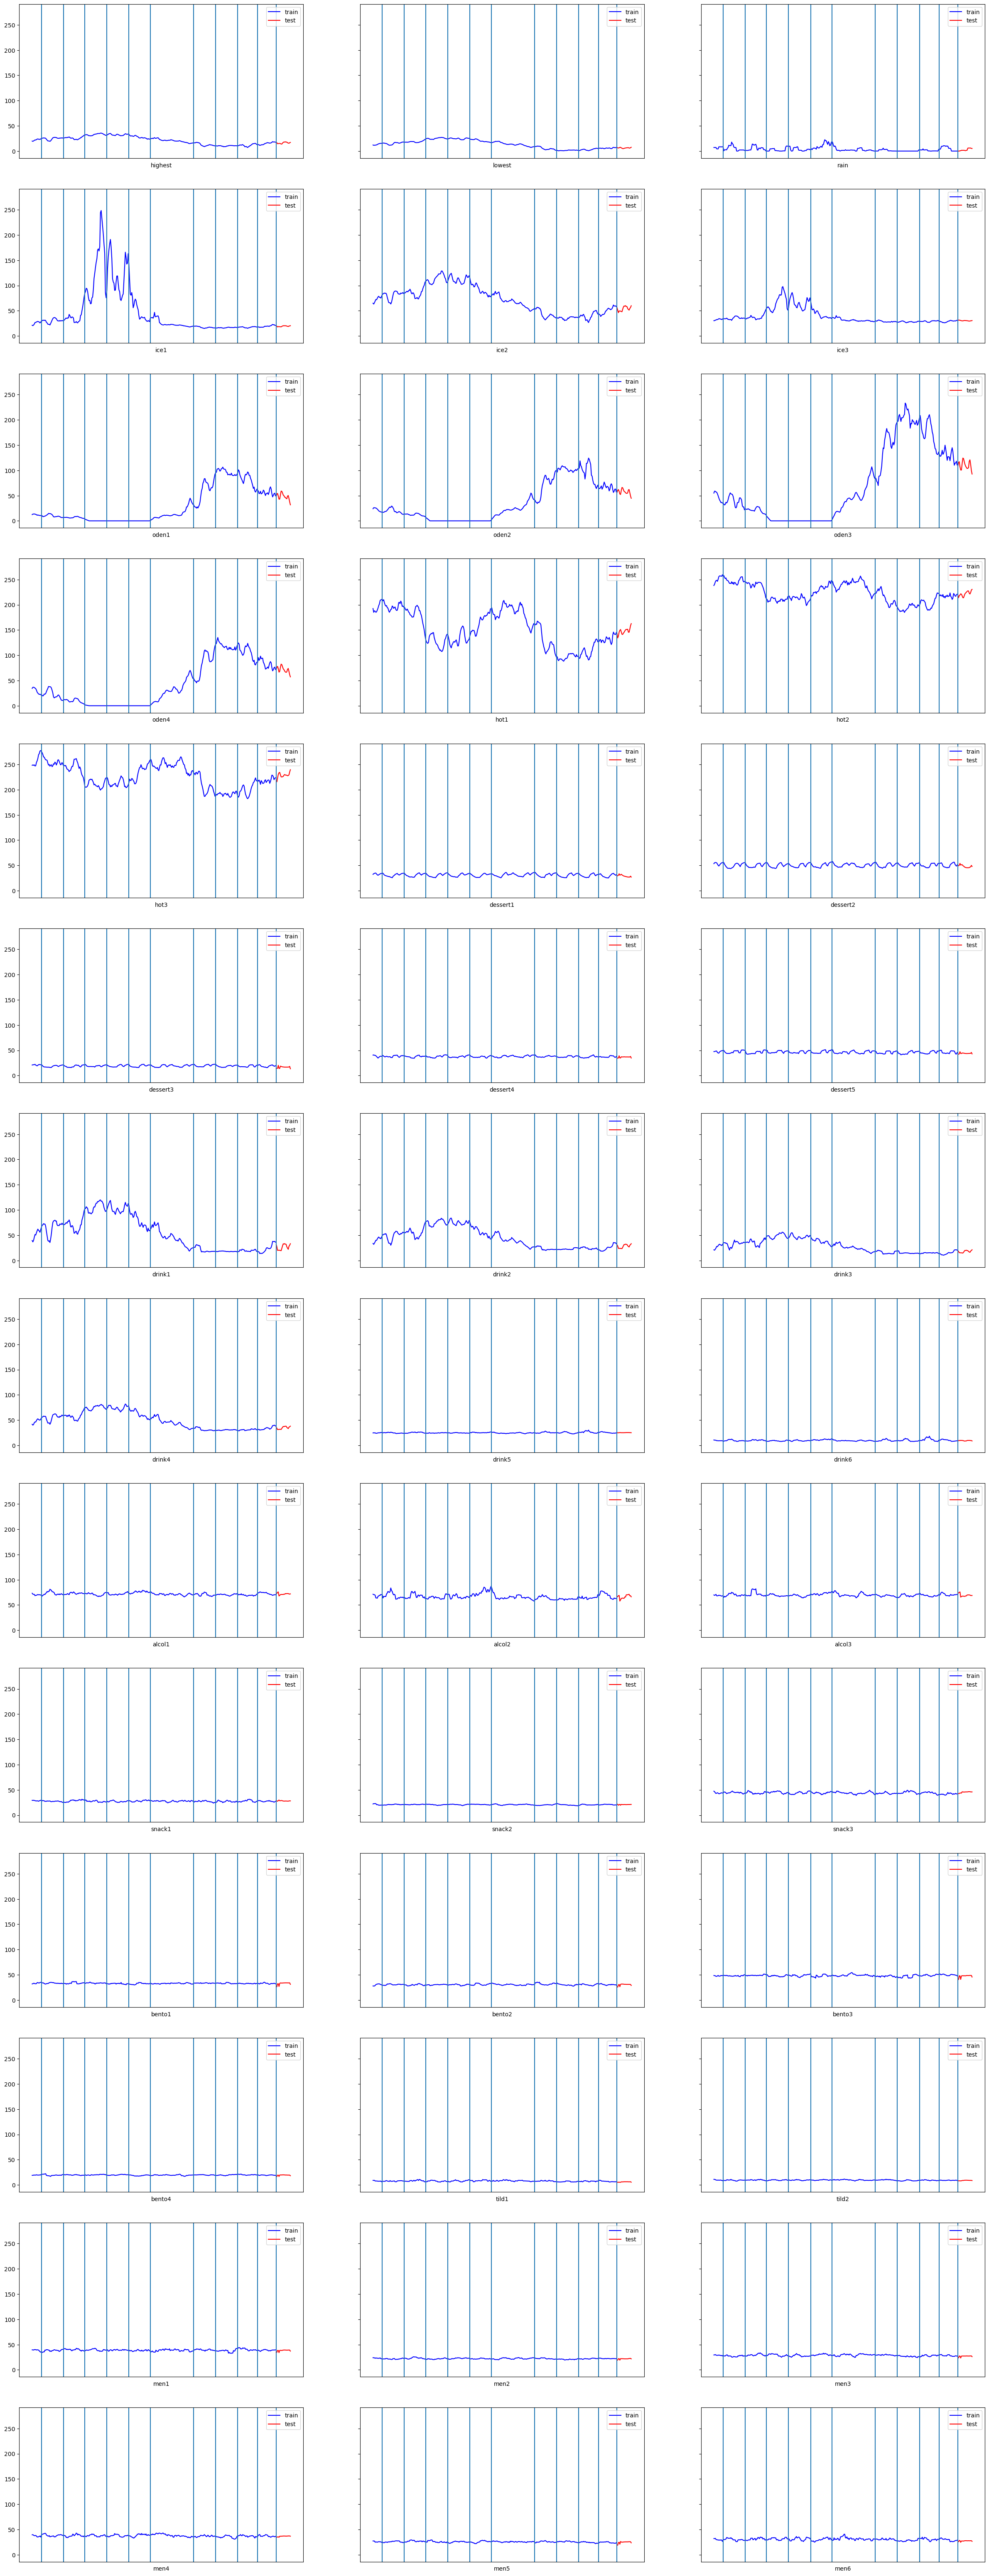

In [24]:
# 目視確認
plot_col = [c for c in train_df.columns if c not in ['id', 'date', 'time', 'year', 'month', 'day', 'weekday']]
ncols = len(plot_col) // 13
plt.subplots(14, ncols, sharey=True, sharex=True, figsize=(30, 80))
for i, col in enumerate(plot_col):
    plt.subplot(14, ncols, i+1)
    plt.plot(train_rolling.index[window:], train_rolling[col][window:], alpha=1, color='blue', label='train')
    plt.plot(all_rolling.index[-len(test_rolling):], all_rolling[col][-len(test_rolling):], alpha=1, color='red', label='test')
    for x in [20,51,81,112,143,173.204,234,265,296,324,350]:
        plt.axvline(x)
    plt.xlabel(col)
    plt.legend()
    plt.xticks([])
plt.show()